In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import json
def get_date(data):
    data_date = []
    for i in range(len(data)):
        mm, dd, yy = data['Date'][i].split('/')
        data_date.append(datetime.date(int('20'+yy), int(mm), int(dd)))
    return data_date
gold_data_path = '/data3/private/fanchenghao/shiyan/gold.csv'
bit_data_path = '/data3/private/fanchenghao/shiyan/bit.csv'
gold_data = pd.read_csv(gold_data_path)
bit_data = pd.read_csv(bit_data_path)
gold_data.rename(columns={'Unnamed: 0':'day', 'Unnamed: 0.1':'id', 'Date':'Date', 'USD (PM)':'USD (PM)'}, inplace = True)
bit_data.rename(columns={'Unnamed: 0':'day', 'Unnamed: 0.1':'id', 'Date':'Date', 'Value':'Value'}, inplace = True)
print(gold_data.columns, bit_data.columns)
gold_data['day']=get_date(gold_data)
bit_data['day']= get_date(bit_data)



Index(['day', 'Date', 'USD (PM)'], dtype='object') Index(['day', 'Date', 'Value'], dtype='object')


In [20]:
n = len(bit_data)

def evaluate_one(testY, predicY, name):
    testY = np.array(testY)
    predicY = np.array(predicY)
    MSE = 0
    for i in range(len(testY)):
        MSE += (testY[i] - predicY[i]) ** 2 / len(testY)
    #MSE=np.sum(np.power((testY.reshape(-1,1) - predicY),2))/len(testY)
    R2=1-MSE/np.var(testY)
    print("{}  MSE:".format(name),MSE)
    print("{}  R^2:".format(name), R2)

def MA(data, money, ma_list=[6,12,24,38,57,137]):
    for ma in ma_list:
        data['MA_'+str(ma)] = data[money].rolling(ma).mean()
        #data['MA_'+str(ma)][0] = data[money][0]
    return data
def BIAS(data, money, ma_list=[6,12,24,38,57,137]): #6,12,24
    for ma in ma_list:
        data['bias_'+str(ma)] = 100*(data[money]-data['MA_'+str(ma)])/data['MA_'+str(ma)]

    return data

def MACD(data, money):
    ema12=data['MA_12']
    ema26=data[money].rolling(26).mean()
    diff=ema12-ema26
    dea=diff.rolling(9).mean()
    macd=2*(diff-dea)
    #plt.figure(figsize=(12,8))
    #plt.plot(data['day'], macd, label='real-data')
    data['MACD']=macd

def PSY(data, money, period=12):
    diff = data[money][1:].to_numpy()-data[money][:-1].to_numpy()
    diff = np.append(0, diff)  
    diff_qu = np.where(diff > 0, 1, 0)
    psy = np.zeros((len(data[money]),))
    psy[:period] *= np.nan
    for i in range(period, len(data[money])):
        psy[i] = (diff_qu[i-period+1:i+1].sum()) / period
    data['PSY']=psy

def calRSI(data, money, periodList=[6,12,24]):
    diff = data[money]-data[money].shift(1)
    
    diff.fillna(0, inplace = True) 
    
    up = diff.copy()
    #过滤掉小于0的值
    up[up<0] = 0
    down = diff.copy()
    #过滤掉大于0的值
    down[down>0] = 0
    #通过for循环，依次计算periodList中不同周期的RSI等值
    for period in periodList:
        upAvg = up.rolling(period).sum()/period
        upAvg.fillna(0, inplace = True)
        downAvg = abs(down.rolling(period).sum()/period)
        downAvg.fillna(0, inplace = True)
        data['RSI_'+str(period)] = 100 - 100/((upAvg/downAvg+1))
    return data

def BOLL(data, money, ma_list=[6,12,24,38,57,137]):
    for ma in ma_list:
        data['UB_'+str(ma)] = data['MA_'+str(ma)] + 2 * data[money].rolling(ma).std()
        data['LB_'+str(ma)] = data['MA_'+str(ma)] - 2 * data[money].rolling(ma).std()
        """plt.figure(figsize=(12,8))
        plt.plot(data['day'], data['UB_'+str(ma)], color='r')
        plt.plot(data['day'], data['LB_'+str(ma)], color='g')
        plt.plot(data['day'], data['MA_'+str(ma)], color='b')"""

def load_pred(data, money, tag='gold'):
    if money == 'Value':
        pred_dict = json.load(open('bit_lstm_pred.json', 'r'))
    else:
        pred_dict = json.load(open('gold_lstm_pred.json', 'r'))

    pred = [np.nan]
    avg15,avg5 = [np.nan], [np.nan]
    da15, xiao15 = [np.nan], [np.nan]
    for i in range(1,50):
        pred.append(0)
        avg15.append(0)
        avg5.append(0)
        da15.append(0)
        xiao15.append(0)
    
    for i in range(50, len(data)):
        pred.append(pred_dict[str(i)]["pred"][0])
        avg = np.average(pred_dict[str(i)]["pred"])
        avg5x = np.average(pred_dict[str(i)]["pred"][:5])
        avg15.append(avg)
        avg5.append(avg5x)
        da, xiao = 0, 0
        for j in range(len(pred_dict[str(i)]["pred"])):
            if(pred_dict[str(i)]["pred"][j] > pred_dict[str(i)]["pred"][0]):
                da += 1
            if(pred_dict[str(i)]["pred"][j] < pred_dict[str(i)]["pred"][0]):
                xiao += 1
        da15.append(da)
        xiao15.append(xiao)

    pred, avg5, avg15=np.array(pred), np.array(avg5), np.array(avg15)

    plt.figure(figsize=(12,8))
    evaluate_one(data[money][50:], pred[50:], tag)
    plt.plot(data['day'][50:], pred[50:], label='real', color='r')
    plt.plot(data['day'][:], data[money][:], label='pred', color='b')
    plt.xlabel('Date')

    if tag == 'gold':
        plt.ylabel('dollar per troy ounce')
        plt.title('Gold Prediction Line From LSTM')
    else:
        plt.ylabel('dollar per bitcoin')
        plt.title('Bitcoin Prediction Line From LSTM')
    plt.legend()
    plt.savefig('./{}_lstm.svg'.format(tag), dpi=400, format="svg")

    pred = (pred[1:] - data[money][:-1].to_numpy()) / data[money][:-1].to_numpy()
    avg5 = (avg5[1:] - data[money][:-1].to_numpy()) / data[money][:-1].to_numpy()
    avg15 = (avg15[1:] - data[money][:-1].to_numpy()) / data[money][:-1].to_numpy()
    pred = np.append(np.nan, pred)
    avg5 = np.append(np.nan, avg5)
    avg15 = np.append(np.nan, avg15)
    for i in range(50):
        pred[i] = avg5[i] = avg15[i] = 0

    data['pred']=pred
    data['avg5']=avg5
    data['avg15']=avg15
    data['more15']=da15
    data['less15']=xiao15




bit  MSE: 1039086.5751055332
bit  R^2: 0.9947729485604938
37
gold  MSE: 291.3900257772761
gold  R^2: 0.9953943442514588
37


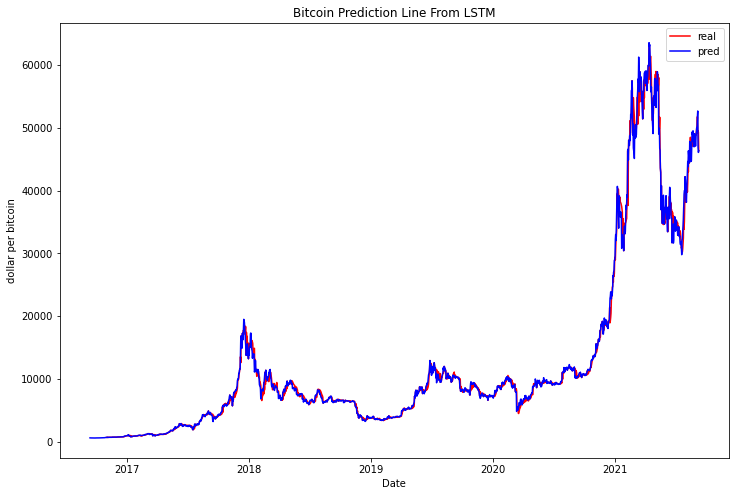

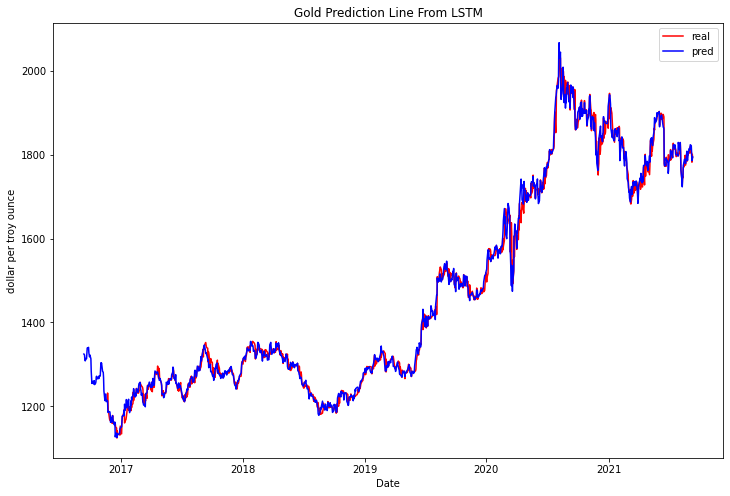

In [21]:
def cun(data, save_name):
    data_dict = []
    for i in range(len(data)):
        dictx = {}
        for key in data.columns:
            if(key == 'day' or key == 'id'):
                dictx[key] = str(data[key][i])
            else:
                if(str(data[key][i]) == "nan"):
                    dictx[key] = "nan"
                else:
                    dictx[key] = data[key][i]
        #print(dictx)
        data_dict.append(dictx)
    with open(save_name, 'w') as f:
        json.dump(data_dict, f, indent=2)
data = MA(bit_data, 'Value')
data = BIAS(data, 'Value')
#data.head(40)
MACD(data, 'Value')
PSY(data, 'Value')
calRSI(data, 'Value')
BOLL(data, 'Value')
load_pred(data, 'Value', 'bit')

print(len(data.columns))

data2 = MA(gold_data, 'USD (PM)')
data2 = BIAS(data2, 'USD (PM)')
#data.head(40)
MACD(data2, 'USD (PM)')
PSY(data2, 'USD (PM)')
calRSI(data2, 'USD (PM)')
BOLL(data2, 'USD (PM)')
load_pred(data2, 'USD (PM)', 'gold')

print(len(data2.columns))

cun(data, 'bit.json')
cun(data2, 'gold.json')
#data.head(80)